In [224]:
import tensorflow as tf
import numpy as np
import cv2
import os
from iou import general_iou
from kmean import kmeans
import matplotlib.pyplot as plt
%matplotlib inline

In [237]:
def get_boxes(path):
    basedir=os.path.dirname(path)
    def _getHW(imagepath):
        I=cv2.imread(imagepath)
        H,W=I.shape[0],I.shape[1]
        return W,H
    anchor_box=[]
    with tf.gfile.GFile(path) as reader:
        lines=reader.readlines()
        for line in lines:
            sps=line.strip().split(' ')
            W,H=_getHW(os.path.join(basedir,sps[0]))
            for j in range(1,len(sps),5):
                x1,y1,x2,y2=float(sps[j]),float(sps[j+1]),float(sps[j+2]),float(sps[j+3])
                anchor_box.append([(x2-x1)/W,(y2-y1)/H])
    anchor_box=np.array(anchor_box)
    return anchor_box

In [238]:
boxes=get_boxes('data/train.txt')

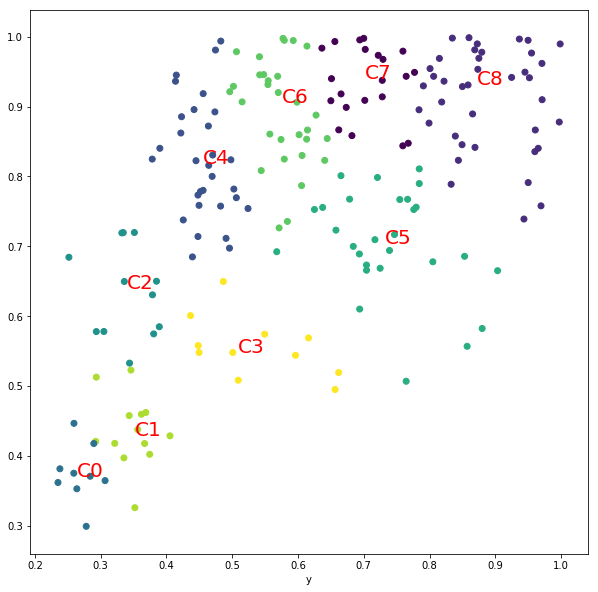

In [363]:
clusters,nearst_cluster,distances=kmeans(boxes,k=9,seed=None)
clusters=sorted(clusters,key=lambda x:x[0]*x[1])
clusters=np.array(clusters)
plt.figure(figsize=(10,10))
plt.scatter(boxes[:,0],boxes[:,1],c=nearst_cluster)
for i,c in enumerate(clusters):
    plt.text(c[0],c[1],'C%d'%i,fontsize=20,color='red')
plt.xlabel('x')
plt.xlabel('y')

In [364]:
def anchorBox2Img(anchorbox,baseUnit=50,seed=None):
    np.random.seed(seed)
    COLORS = np.random.randint(0, 255, size=(len(anchorbox), 3))
    COLORS=[( int(c[0]),int(c[1]),int(c[2]) )for c in COLORS]
    anchor_boxes=sorted(anchorbox,key=lambda x:x[0]*x[1])
    Ws=[int(baseUnit*box[0]) for box in anchor_boxes]
    #注意uint32,设置8溢出错误
    offset=np.cumsum (np.concatenate([[0.0],Ws]) ).astype(np.uint32)

    Hs=[int(baseUnit*box[1]) for box in anchor_boxes]
    WW,HH=sum(Ws),max(Hs)
    I=np.zeros((HH,WW),np.uint8)
    
    for i in range(len(Hs)):
        s=offset[i]
        pt1=(s,0)
        pt2=(s+Ws[i],Hs[i])
        I=cv2.rectangle(I,pt1,pt2,COLORS[i],-1)
        I=cv2.putText(I,'C%d'%i,(s+Ws[i]//2-10,Hs[i]//2),cv2.FONT_ITALIC,2,0.5,3)
    return I

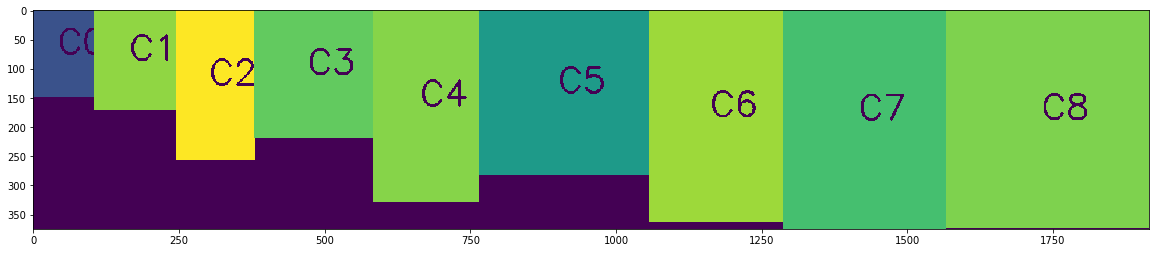

In [365]:
I=anchorBox2Img(clusters,400,seed=26)
plt.figure(figsize=(20,20))
plt.imshow(I)